<a href="https://colab.research.google.com/github/anushkaa-10/NLP/blob/main/News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd

df = pd.read_json("/content/news_dataset.json")
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [28]:
!python -m spacy download en_core_web_lg

import spacy
nlp = spacy.load("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
df.shape

(12695, 2)

In [17]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [19]:
minority_count = df['category'].value_counts().min()

balanced_df = pd.DataFrame()
for category in df['category'].unique():
  category_df = df[df['category'] == category].sample(n=minority_count, random_state=42)
  balanced_df = pd.concat([balanced_df, category_df])

print(balanced_df['category'].value_counts())

category
SCIENCE     1381
BUSINESS    1381
CRIME       1381
SPORTS      1381
Name: count, dtype: int64


In [22]:
df['label_num'] = df['category'].map({'SCIENCE': 0, 'BUSINESS': 1, 'politics': 2, 'CRIME': 3, 'SPORTS': 4})
df.head()

,text,category,label_num
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,0
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,0
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,1
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,1
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,3


### Preprocessing Text

In [23]:
def preprocessing(text):
  doc = nlp(text)
  filtered_tokens = []
  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    filtered_tokens.append(token.lemma_)
  return ' '.join(filtered_tokens)

In [29]:
df['preprocessed_text'] = df['text'].apply(lambda text: preprocessing(text))

In [30]:
df.head()

,text,category,label_num,preprocessed_text
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,0,watch Schrödinger Cat Die University Californi...
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,0,watch freaky Vortex open Flooded Lake
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,1,entrepreneur today need Big Budget start year ...
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,1,road recharge Electric Car drive high tech hig...
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,3,civilian Guard Fires Gun protect Recruiting Ce...


In [32]:
df['vector'] = df['preprocessed_text'].apply(lambda text: nlp(text).vector)
df.head()

,text,category,label_num,preprocessed_text,vector
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,0,watch Schrödinger Cat Die University Californi...,"[-0.85190785, 1.0438694, -0.9148885, -1.395817..."
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,0,watch freaky Vortex open Flooded Lake,"[0.60747343, 1.9251899, -0.16949336, -0.573053..."
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,1,entrepreneur today need Big Budget start year ...,"[0.088981755, 0.5882564, -1.2281352, -0.320762..."
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,1,road recharge Electric Car drive high tech hig...,"[-1.0280653, 4.349204, -1.06896, -1.045683, 1...."
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,3,civilian Guard Fires Gun protect Recruiting Ce...,"[-1.4220493, 0.9367255, -1.8070079, 3.1870718,..."


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['vector'],
    df['label_num'],
    test_size=0.2,
    random_state=42
  )

In [34]:
import numpy as np
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier()
clf.fit(X_train_2d, y_train)

DecisionTreeClassifier()

In [39]:
y_pred = clf.predict(X_test_2d)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.41      0.41       276
           1       0.70      0.68      0.69       874
           3       0.65      0.67      0.66       578
           4       0.70      0.71      0.70       811

    accuracy                           0.66      2539
   macro avg       0.61      0.62      0.61      2539
weighted avg       0.66      0.66      0.66      2539



In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = MultinomialNB()

clf.fit(scaled_train_embed , y_train)

y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       276
           1       0.64      0.86      0.73       874
           3       0.93      0.54      0.68       578
           4       0.66      0.84      0.74       811

    accuracy                           0.69      2539
   macro avg       0.81      0.56      0.54      2539
weighted avg       0.75      0.69      0.64      2539



In [41]:
from  sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       276
           1       0.79      0.90      0.84       874
           3       0.82      0.85      0.83       578
           4       0.89      0.81      0.85       811

    accuracy                           0.83      2539
   macro avg       0.84      0.80      0.81      2539
weighted avg       0.84      0.83      0.83      2539



In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.55      0.69       276
           1       0.81      0.90      0.85       874
           3       0.87      0.84      0.85       578
           4       0.84      0.87      0.85       811

    accuracy                           0.84      2539
   macro avg       0.86      0.79      0.81      2539
weighted avg       0.84      0.84      0.83      2539

              precision    recall  f1-score   support

           0       0.91      0.52      0.66       276
           1       0.81      0.90      0.85       874
           3       0.87      0.83      0.85       578
           4       0.82      0.87      0.84       811

    accuracy                           0.83      2539
   macro avg       0.85      0.78      0.80      2539
weighted avg       0.84      0.83      0.83      2539



In [43]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       276
           1       0.86      0.91      0.89       874
           3       0.87      0.87      0.87       578
           4       0.88      0.87      0.88       811

    accuracy                           0.87      2539
   macro avg       0.87      0.85      0.86      2539
weighted avg       0.87      0.87      0.87      2539



Text(95.72222222222221, 0.5, 'Truth')

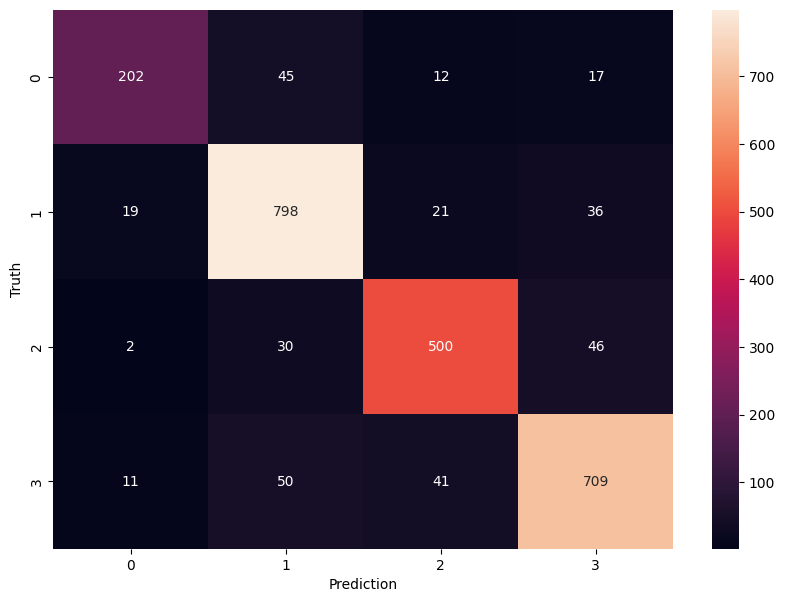

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')